# Using MLJ to classifiy the MNIST image dataset

In [1]:
using Pkg
const DIR = @__DIR__
Pkg.activate(DIR)
Pkg.instantiate()

  Activating project at `~/GoogleDrive/Julia/MLJ/MLJFlux/examples/mnist`


**Julia version** is assumed to be ^1.7

In [2]:
using MLJ
using Flux
import MLJFlux
import MLJIteration # for `skip`

using Plots
gr(size=(600, 300*(sqrt(5)-1)));

┌ Info: Precompiling MLJ [add582a8-e3ab-11e8-2d5e-e98b27df1bc7]
└ @ Base loading.jl:1423


## Basic training

Downloading the MNIST image dataset:

In [3]:
import MLDatasets: MNIST

ENV["DATADEPS_ALWAYS_ACCEPT"] = true
images, labels = MNIST.traindata();

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1423
┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets /Users/anthony/.julia/packages/MLDatasets/eZ0Va/src/datasets/vision/mnist.jl:187


In MLJ, integers cannot be used for encoding categorical data, so we
must force the labels to have the `Multiclass` [scientific
type](https://juliaai.github.io/ScientificTypes.jl/dev/). For
more on this, see [Working with Categorical
Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/).

In [4]:
labels = coerce(labels, Multiclass);
images = coerce(images, GrayImage);

Checking scientific types:

In [5]:
@assert scitype(images) <: AbstractVector{<:Image}
@assert scitype(labels) <: AbstractVector{<:Finite}

Looks good.

For general instructions on coercing image data, see [Type coercion
for image
data](https://alan-turing-institute.github.io/ScientificTypes.jl/dev/#Type-coercion-for-image-data-1)

In [6]:
images[1]

We start by defining a suitable `Builder` object. This is a recipe
for building the neural network. Our builder will work for images of
any (constant) size, whether they be color or black and white (ie,
single or multi-channel).  The architecture always consists of six
alternating convolution and max-pool layers, and a final dense
layer; the filter size and the number of channels after each
convolution layer is customisable.

In [7]:
import MLJFlux
struct MyConvBuilder
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

make2d(x::AbstractArray) = reshape(x, :, size(x)[end])

function MLJFlux.build(b::MyConvBuilder, rng, n_in, n_out, n_channels)
    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3
    mod(k, 2) == 1 || error("`filter_size` must be odd. ")
    p = div(k - 1, 2) # padding to preserve image size
    init = Flux.glorot_uniform(rng)
    front = Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c1 => c2, pad=(p, p), relu, init=init),
        MaxPool((2, 2)),
        Conv((k, k), c2 => c3, pad=(p, p), relu, init=init),
        MaxPool((2 ,2)),
        make2d)
    d = Flux.outputsize(front, (n_in..., n_channels, 1)) |> first
    return Chain(front, Dense(d, n_out, init=init))
end

**Note.** There is no final `softmax` here, as this is applied by
default in all MLJFLux classifiers. Customisation of this behaviour
is controlled using using the `finaliser` hyperparameter of the
classifier.

We now define the MLJ model. If you have a GPU, substitute
`acceleration=CUDALibs()` below:

In [8]:
ImageClassifier = @load ImageClassifier
clf = ImageClassifier(builder=MyConvBuilder(3, 16, 32, 32),
                      batch_size=50,
                      epochs=10,
                      rng=123)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/lDzCR/src/loading.jl:168


import MLJFlux ✔


ImageClassifier(
  builder = MyConvBuilder(3, 16, 32, 32), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 50, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 123, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

You can add Flux options `optimiser=...` and `loss=...` here. At
present, `loss` must be a Flux-compatible loss, not an MLJ
measure. To run on a GPU, set `acceleration=CUDALib()`.

Binding the model with data in an MLJ machine:

In [9]:
mach = machine(clf, images, labels);

Training for 10 epochs on the first 500 images:

In [10]:
fit!(mach, rows=1:500, verbosity=2);

┌ Info: Training machine(ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …).
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/Fl6Zc/src/machines.jl:498
┌ Info: Loss is 2.291
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 2.208
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 2.049
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 1.685
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 1.075
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 0.628
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 0.4639
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 0.361
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/n3YAv/src/core.jl:127
┌ Info: Loss is 0.2921
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux

Inspecting:

In [11]:
report(mach)

(training_losses = Float32[2.3242702, 2.2908378, 2.20822, 2.0489829, 1.6850392, 1.0751165, 0.6279615, 0.46388212, 0.36103815, 0.29207793, 0.2478443],)

In [12]:
chain = fitted_params(mach)

(chain = Chain(Chain(Chain(Conv((3, 3), 1 => 16, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 16 => 32, relu, pad=1), MaxPool((2, 2)), Conv((3, 3), 32 => 32, relu, pad=1), MaxPool((2, 2)), make2d), Dense(288 => 10)), softmax),)

In [13]:
Flux.params(chain)[2]

16-element Vector{Float32}:
  0.011803599
  0.05579675
  8.461591f-5
  0.013422165
 -0.001925053
  0.011568692
 -0.00051727734
 -0.0003228416
  0.03614383
  0.06365696
 -0.0005846103
 -0.004092362
  0.0036211032
  0.0031117066
  0.02764553
  0.05152524

Adding 20 more epochs:

In [14]:
clf.epochs = clf.epochs + 20
fit!(mach, rows=1:500);

┌ Info: Updating machine(ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …).
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/Fl6Zc/src/machines.jl:499
Optimising neural net: 100%[=========================] Time: 0:00:08


Computing an out-of-sample estimate of the loss:

In [15]:
predicted_labels = predict(mach, rows=501:1000);
cross_entropy(predicted_labels, labels[501:1000]) |> mean

0.36284238f0

Or, in one line:

In [16]:
evaluate!(mach,
          resampling=Holdout(fraction_train=0.5),
          measure=cross_entropy,
          rows=1:1000,
          verbosity=0)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────────────┬───────────┬─────────────┬────────────────┐
│ measure                        │ operation │ measurement │ per_fold       │
├────────────────────────────────┼───────────┼─────────────┼────────────────┤
│ LogLoss(                       │ predict   │ 0.363       │ Float32[0.363] │
│   tol = 2.220446049250313e-16) │           │             │                │
└────────────────────────────────┴───────────┴─────────────┴────────────────┘


## Wrapping the MLJFlux model with iteration controls

Any iterative MLJFlux model can be wrapped in *iteration controls*,
as we demonstrate next. For more on MLJ's `IteratedModel` wrapper,
see the [MLJ
documentation](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/).

The "self-iterating" classifier, called `iterated_clf` below, is for
iterating the image classifier defined above until one of the
following stopping criterion apply:

- `Patience(3)`: 3 consecutive increases in the loss
- `InvalidValue()`: an out-of-sample loss, or a training loss, is `NaN`, `Inf`, or `-Inf`
- `TimeLimit(t=5/60)`: training time has exceeded 5 minutes

These checks (and other controls) will be applied every two epochs
(because of the `Step(2)` control). Additionally, training a
machine bound to `iterated_clf` will:

- save a snapshot of the machine every three control cycles (every six epochs)
- record traces of the out-of-sample loss and training losses for plotting
- record mean value traces of each Flux parameter for plotting

For a complete list of controls, see [this
table](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/#Controls-provided).

### Wrapping the classifier

Some helpers

In [17]:
make2d(x::AbstractArray) = reshape(x, :, size(x)[end])
make1d(x::AbstractArray) = reshape(x, length(x));

To extract Flux params from an MLJFlux machine

In [18]:
parameters(mach) = make1d.(Flux.params(fitted_params(mach)));

To store the traces:

In [19]:
losses = []
training_losses = []
parameter_means = Float32[];
epochs = []

Any[]

To update the traces:

In [20]:
update_loss(loss) = push!(losses, loss)
update_training_loss(losses) = push!(training_losses, losses[end])
update_means(mach) = append!(parameter_means, mean.(parameters(mach)));
update_epochs(epoch) = push!(epochs, epoch)

update_epochs (generic function with 1 method)

The controls to apply:

In [21]:
save_control =
    MLJIteration.skip(Save(joinpath(DIR, "mnist.jlso")), predicate=3)

controls=[Step(2),
          Patience(3),
          InvalidValue(),
          TimeLimit(5/60),
          save_control,
          WithLossDo(),
          WithLossDo(update_loss),
          WithTrainingLossesDo(update_training_loss),
          Callback(update_means),
          WithIterationsDo(update_epochs)
];

The "self-iterating" classifier:

In [22]:
iterated_clf = IteratedModel(model=clf,
                       controls=controls,
                       resampling=Holdout(fraction_train=0.7),
                       measure=log_loss)

ProbabilisticIteratedModel(
  model = ImageClassifier(
        builder = MyConvBuilder(3, 16, 32, 32), 
        finaliser = NNlib.softmax, 
        optimiser = Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
        loss = Flux.Losses.crossentropy, 
        epochs = 30, 
        batch_size = 50, 
        lambda = 0.0, 
        alpha = 0.0, 
        rng = 123, 
        optimiser_changes_trigger_retraining = false, 
        acceleration = CPU1{Nothing}(nothing)), 
  controls = Any[Step(2), Patience(3), InvalidValue(), TimeLimit(Dates.Millisecond(300000)), IterationControl.Skip{Save{typeof(Serialization.serialize)}, IterationControl.var"#8#9"{Int64}}(Save{typeof(Serialization.serialize)}("/Users/anthony/GoogleDrive/Julia/MLJ/MLJFlux/examples/mnist/mnist.jlso", Serialization.serialize), IterationControl.var"#8#9"{Int64}(3)), WithLossDo{IterationControl.var"#20#22"}(IterationControl.var"#20#22"(), false, nothing), WithLossDo{typeof(update_loss)}(update_loss, false, nothing), WithTra

### Binding the wrapped model to data:

In [23]:
mach = machine(iterated_clf, images, labels);

### Training

In [24]:
fit!(mach, rows=1:500);

┌ Info: Training machine(ProbabilisticIteratedModel(model = ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …), …).
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/Fl6Zc/src/machines.jl:498
┌ Info: No iteration parameter specified. Using `iteration_parameter=:(epochs)`. 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/J0pbp/src/core.jl:62
┌ Info: loss: 2.224743
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 1.968148
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: Saving "/Users/anthony/GoogleDrive/Julia/MLJ/MLJFlux/examples/mnist/mnist1.jlso". 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/J0pbp/src/controls.jl:203
┌ Info: loss: 1.2209107
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.5940933
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx

### Comparison of the training and out-of-sample losses:

In [25]:
plot(epochs, losses,
     xlab = "epoch",
     ylab = "cross entropy",
     label="out-of-sample")
plot!(epochs, training_losses, label="training")

savefig(joinpath(DIR, "loss.png"))

### Evolution of weights

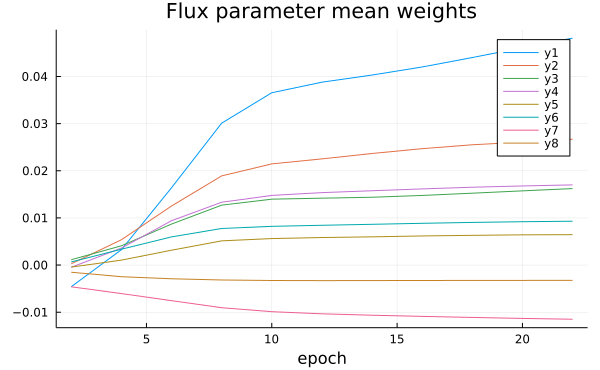

In [26]:
n_epochs =  length(losses)
n_parameters = div(length(parameter_means), n_epochs)
parameter_means2 = reshape(copy(parameter_means), n_parameters, n_epochs)'
plot(epochs, parameter_means2,
     title="Flux parameter mean weights",
     xlab = "epoch")

**Note.** The the higher the number, the deeper the chain parameter.

In [27]:
savefig(joinpath(DIR, "weights.png"))

### Retrieving a snapshot for a prediction:

In [28]:
mach2 = machine(joinpath(DIR, "mnist3.jlso"))
predict_mode(mach2, images[501:503])

3-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 7
 9
 5

### Restarting training

Mutating `iterated_clf.controls` or `clf.epochs` (which is otherwise
ignored) will allow you to restart training from where it left off.

┌ Info: Updating machine(ProbabilisticIteratedModel(model = ImageClassifier(builder = MyConvBuilder(3, 16, 32, 32), …), …), …).
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/Fl6Zc/src/machines.jl:499
┌ Info: loss: 0.444918
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.4575673
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: Saving "/Users/anthony/GoogleDrive/Julia/MLJ/MLJFlux/examples/mnist/mnist1.jlso". 
└ @ MLJIteration /Users/anthony/.julia/packages/MLJIteration/J0pbp/src/controls.jl:203
┌ Info: loss: 0.46934554
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.48012888
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: loss: 0.49023148
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/wJWPx/src/controls.jl:278
┌ Info: final loss: 

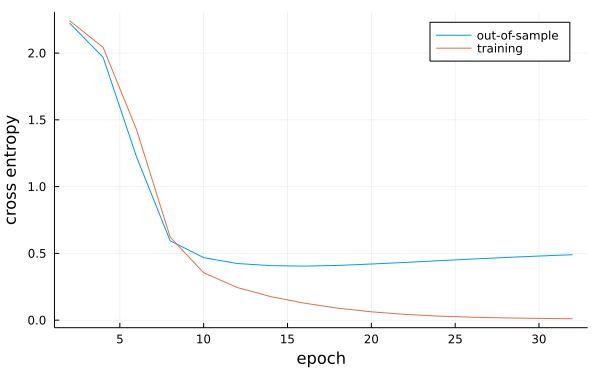

In [29]:
iterated_clf.controls[2] = Patience(4)
fit!(mach, rows=1:500)

plot(epochs, losses,
     xlab = "epoch",
     ylab = "cross entropy",
     label="out-of-sample")
plot!(epochs, training_losses, label="training")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*